# properties of each water mass and how they vary

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [4]:
def organize(s_t, do_no3, ta_dic, region, final=True):
    # make dictionary of transport and tracer concentrations of each water parcel within a specified region
    
    # the region is based on the boolean input into the function defined here
    # region options are salish, cuc, offshore deep, offshore surface, north, south, fresh, loop
    mydata= s_t
    # boundary definitions
    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4
    saltdiv = 32
    sdiv = 33.5
    if region == 'salish':
        boolean = ((abs(mydata.init_t-mydata.final_t) > 24) & ~np.isnan(mydata.final_section))
    elif region == 'cuc':
        boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= sdiv)
    elif region == 'offshore deep':
        boolean = (mydata.final_section==bdy_off) & (mydata.final_depth > 120)
    elif region == 'offshore surface':
        boolean = (mydata.final_section==bdy_off) & (mydata.final_depth <=120)
    elif region == 'north':
        boolean = (mydata.final_section==bdy_nor)
    elif region == 'south':
        boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)
    elif region == 'fresh':
        boolean = ((mydata.final_section==bdy_sou) & (mydata.final_salt < saltdiv))
    elif region == 'loop':
        boolean = (mydata.final_section==bdy_loo) & (abs(mydata.init_t-mydata.final_t) > 24)
    else:
        print('not in the list of regions, options are: salish, cuc, offshore deep, offshore surface, north, south, fresh, loop')
    


    if final==True: # ie. looking at the water parcels at the outer boundaries
        # get data
        transport = mydata.init_transp[boolean].values
        salt = mydata.init_salt[boolean].values
        temp = mydata.init_temp[boolean].values
        mydata = do_no3
        NO3 = mydata.init_salt[boolean].values
        DO = mydata.init_temp[boolean].values
        mydata = ta_dic
        DIC = mydata.init_salt[boolean].values
        TA = mydata.init_temp[boolean].values
    else: # ie. looking at the water parcels at the JdF boundary
        # get data
        transport = mydata.final_transp[boolean].values
        salt = mydata.final_salt[boolean].values
        temp = mydata.final_temp[boolean].values
        mydata = do_no3
        NO3 = mydata.final_salt[boolean].values
        DO = mydata.final_temp[boolean].values
        mydata = ta_dic
        DIC = mydata.final_salt[boolean].values
        TA = mydata.final_temp[boolean].values

    # set up dictionary
    d = {'transport':transport,'salt':salt,'temp':temp,'DO':DO,'NO3':NO3,'TA':TA,'DIC':DIC}
    df = pd.DataFrame(d)

    return df

## Properties into JdF

In [5]:
region = 'salish'
final = False

up13 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20131024/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20131024/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20131024/ariane_positions_quantitative.nc'),
             region, final)

up14 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20140903/ariane_positions_quantitative.nc'),
             region, final)

up15 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20150905/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20150905/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20150905/ariane_positions_quantitative.nc'),
             region, final)

up16 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20160913/ariane_positions_quantitative.nc'),
             region, final)

up17 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20171012/ariane_positions_quantitative.nc'),
             region, final)

up18 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20180906/ariane_positions_quantitative.nc'),
             region, final)

up21 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20210922/ariane_positions_quantitative.nc'),
             region, final)

up22 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20221015/ariane_positions_quantitative.nc'),
             region, final)

In [6]:
dw13 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20140306/ariane_positions_quantitative.nc'),
             region, final)

dw15 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20160319/ariane_positions_quantitative.nc'),
             region, final)

dw16 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20170419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20170419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20170419/ariane_positions_quantitative.nc'),
             region, final)

dw17 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20180201/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20180201/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20180201/ariane_positions_quantitative.nc'),
             region, final)

dw19 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20200127/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20200127/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20200127/ariane_positions_quantitative.nc'),
             region, final)

dw20 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20210202/ariane_positions_quantitative.nc'),
             region, final)

dw21 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20220125/ariane_positions_quantitative.nc'),
             region, final)

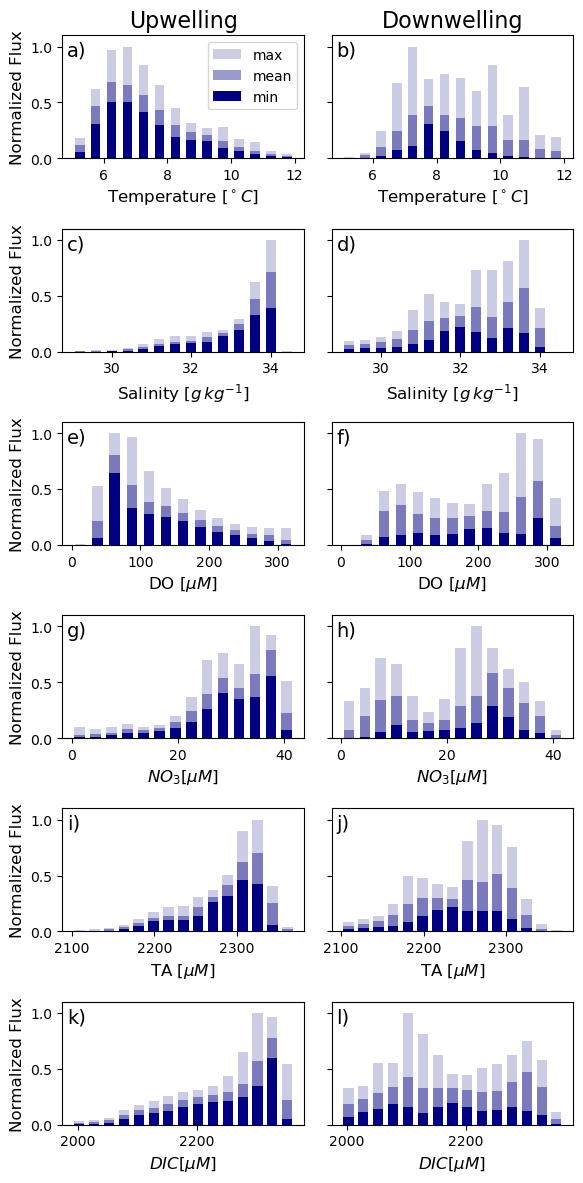

In [7]:
fig, ax = plt.subplots(6, 2, figsize = (6, 12))
plt.rcParams['font.size'] = 12

#TEMPERATURE
bins = np.arange(5,12.5,0.5)
#plt upwelling
h,x,_ = ax[0,0].hist([up13.temp,up14.temp,up15.temp,up16.temp,up17.temp,up18.temp,up21.temp,up22.temp], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[0,0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,0].set_title('Upwelling', fontsize = 16)
ax[0,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[0,0].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,0].set_ylim([0,1.1])
ax[0,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[0,1].hist([dw13.temp,dw15.temp,dw16.temp,dw17.temp,dw19.temp,dw20.temp,dw21.temp], bins=bins,
                             weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[0,1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,1].set_title('Downwelling', fontsize = 16)
ax[0,1].set_yticklabels([])
ax[0,1].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#SALINITY
bins = np.arange(29,34.8,0.4)
#plt upwelling
h,x,_ = ax[1,0].hist([up13.salt,up14.salt,up15.salt,up16.salt,up17.salt,up18.salt,up21.salt,up22.salt], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[1,0].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,0].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,0].bar(bin_centers, mini,width = 0.25, color='navy',label='min')

# ax[0].set_title('Winter')
ax[1,0].set_ylabel('Normalized Flux', fontsize=12)
ax[1,0].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[1,1].hist([dw13.salt,dw15.salt,dw16.salt,dw17.salt,dw19.salt,dw20.salt,dw21.salt], bins=bins, 
                           weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[1,1].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,1].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,1].bar(bin_centers, mini,width = 0.25, color='navy',label='min')


ax[1,1].set_yticklabels([])#,fontsize=14)
ax[1,1].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,1].set_ylim([0,1.1])

#DO
bins = np.arange(0,350,25)
#plt upwelling
h,x,_ = ax[2,0].hist([up13.DO,up14.DO,up15.DO,up16.DO,up17.DO,up18.DO,up21.DO,up22.DO], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[2,0].bar(bin_centers,maxi,width = 15,color='navy',alpha=0.2,label='max')
ax[2,0].bar(bin_centers,mean,width = 15, color='navy',alpha=0.4,label='mean')
ax[2,0].bar(bin_centers, mini,width = 15, color='navy',label='min')

ax[2,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[2,0].set_xlabel('DO [$\mu M$]', fontsize = 12)
ax[2,0].set_ylim([0,1.1])
# ax[2,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[2,1].hist([dw13.DO,dw15.DO,dw16.DO,dw17.DO,dw19.DO,dw20.DO,dw21.DO], bins=bins,
                             weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[2,1].bar(bin_centers,maxi,width = 15,color='navy',alpha=0.2,label='max')
ax[2,1].bar(bin_centers,mean,width = 15, color='navy',alpha=0.4,label='mean')
ax[2,1].bar(bin_centers, mini,width = 15, color='navy',label='min')

ax[2,1].set_yticklabels([])
ax[2,1].set_xlabel('DO [$\mu M$]', fontsize = 12)
ax[2,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#NO3
bins = np.arange(0,45,3)
#plt upwelling
h,x,_ = ax[3,0].hist([up13.NO3,up14.NO3,up15.NO3,up16.NO3,up17.NO3,up18.NO3,up21.NO3,up22.NO3], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[3,0].bar(bin_centers,maxi,width = 2,color='navy',alpha=0.2,label='max')
ax[3,0].bar(bin_centers,mean,width = 2, color='navy',alpha=0.4,label='mean')
ax[3,0].bar(bin_centers, mini,width = 2, color='navy',label='min')

# ax[0].set_title('Winter')
ax[3,0].set_ylabel('Normalized Flux', fontsize=12)
ax[3,0].set_xlabel('$NO_3 [\mu M$]', fontsize=12)
ax[3,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[3,1].hist([dw13.NO3,dw15.NO3,dw16.NO3,dw17.NO3,dw19.NO3,dw20.NO3,dw21.NO3], bins=bins, 
                           weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[3,1].bar(bin_centers,maxi,width = 2,color='navy',alpha=0.2,label='max')
ax[3,1].bar(bin_centers,mean,width = 2, color='navy',alpha=0.4,label='mean')
ax[3,1].bar(bin_centers, mini,width = 2, color='navy',label='min')


ax[3,1].set_yticklabels([])#,fontsize=14)
ax[3,1].set_xlabel('$NO_3 [\mu M$]', fontsize=12)
ax[3,1].set_ylim([0,1.1])

#TA
bins = np.arange(2100,2380,18)
#plt upwelling
h,x,_ = ax[4,0].hist([up13.TA,up14.TA,up15.TA,up16.TA,up17.TA,up18.TA,up21.TA,up22.TA], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[4,0].bar(bin_centers,maxi,width = 13,color='navy',alpha=0.2,label='max')
ax[4,0].bar(bin_centers,mean,width = 13, color='navy',alpha=0.4,label='mean')
ax[4,0].bar(bin_centers, mini,width = 13, color='navy',label='min')

ax[4,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[4,0].set_xlabel('TA [$\mu M$]', fontsize = 12)
ax[4,0].set_ylim([0,1.1])
# ax[2,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[4,1].hist([dw13.TA,dw15.TA,dw16.TA,dw17.TA,dw19.TA,dw20.TA,dw21.TA], bins=bins,
                             weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[4,1].bar(bin_centers,maxi,width = 13,color='navy',alpha=0.2,label='max')
ax[4,1].bar(bin_centers,mean,width = 13, color='navy',alpha=0.4,label='mean')
ax[4,1].bar(bin_centers, mini,width = 13, color='navy',label='min')

ax[4,1].set_yticklabels([])
ax[4,1].set_xlabel('TA [$\mu M$]', fontsize = 12)
ax[4,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#DIC
bins = np.arange(1990,2380,25)
#plt upwelling
h,x,_ = ax[5,0].hist([up13.DIC,up14.DIC,up15.DIC,up16.DIC,up17.DIC,up18.DIC,up21.DIC,up22.DIC], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[5,0].bar(bin_centers,maxi,width = 17,color='navy',alpha=0.2,label='max')
ax[5,0].bar(bin_centers,mean,width = 17, color='navy',alpha=0.4,label='mean')
ax[5,0].bar(bin_centers, mini,width = 17, color='navy',label='min')

ax[5,0].set_ylabel('Normalized Flux', fontsize=12)
ax[5,0].set_xlabel('$DIC [\mu M$]', fontsize=12)
ax[5,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[5,1].hist([dw13.DIC,dw15.DIC,dw16.DIC,dw17.DIC,dw19.DIC,dw20.DIC,dw21.DIC], bins=bins, 
                           weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[5,1].bar(bin_centers,maxi,width = 17,color='navy',alpha=0.2,label='max')
ax[5,1].bar(bin_centers,mean,width = 17, color='navy',alpha=0.4,label='mean')
ax[5,1].bar(bin_centers, mini,width = 17, color='navy',label='min')


ax[5,1].set_yticklabels([])#,fontsize=14)
ax[5,1].set_xlabel('$DIC [\mu M$]', fontsize=12)
ax[5,1].set_ylim([0,1.1])

#labels#labels#labels
ax[0,0].text(.02, .8, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=14)
ax[0,1].text(.02, .8, 'b)', ha='left', va='bottom', transform=ax[0,1].transAxes, fontsize=14)
ax[1,0].text(.02, .8, 'c)', ha='left', va='bottom', transform=ax[1,0].transAxes, fontsize=14)
ax[1,1].text(.02, .8, 'd)', ha='left', va='bottom', transform=ax[1,1].transAxes, fontsize=14)
ax[2,0].text(.02, .8, 'e)', ha='left', va='bottom', transform=ax[2,0].transAxes, fontsize=14)
ax[2,1].text(.02, .8, 'f)', ha='left', va='bottom', transform=ax[2,1].transAxes, fontsize=14)
ax[3,0].text(.02, .8, 'g)', ha='left', va='bottom', transform=ax[3,0].transAxes, fontsize=14)
ax[3,1].text(.02, .8, 'h)', ha='left', va='bottom', transform=ax[3,1].transAxes, fontsize=14)
ax[4,0].text(.02, .8, 'i)', ha='left', va='bottom', transform=ax[4,0].transAxes, fontsize=14)
ax[4,1].text(.02, .8, 'j)', ha='left', va='bottom', transform=ax[4,1].transAxes, fontsize=14)
ax[5,0].text(.02, .8, 'k)', ha='left', va='bottom', transform=ax[5,0].transAxes, fontsize=14)
ax[5,1].text(.02, .8, 'l)', ha='left', va='bottom', transform=ax[5,1].transAxes, fontsize=14)

plt.tight_layout()

## interannual variability

In [35]:
up13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2013.csv')
up14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2014.csv')
up15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2015.csv')
up16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2016.csv')
up17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2017.csv')
up18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2018.csv')
up21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2021.csv')
up22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2022.csv')

dw13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2014.csv')
dw15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2016.csv')
dw16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2017.csv')
dw17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2018.csv')
dw19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2020.csv')
dw20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2021.csv')
dw21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2022.csv')

In [36]:
def interannual(region, property, updown):
    if updown == 'up':
        files = [up13, up14, up15, up16, up17, up18, up21, up22]
    elif updown == 'down':
        files = [dw13, dw15, dw16, dw17, dw19, dw20, dw21]
    elif updown == 'both':
        files = [up13, dw13, up14, up15, dw15, up16, dw16, up17, dw17, up18, dw19, dw20, up21, dw21, up22]

    data = np.zeros(len(files))
    i = 0
    for file in files:
        data[i] = file[property][file.regions == region]
        i+=1

    return data

/tmp/ipykernel_54755/967043055.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data[i] = file[property][file.regions == region]


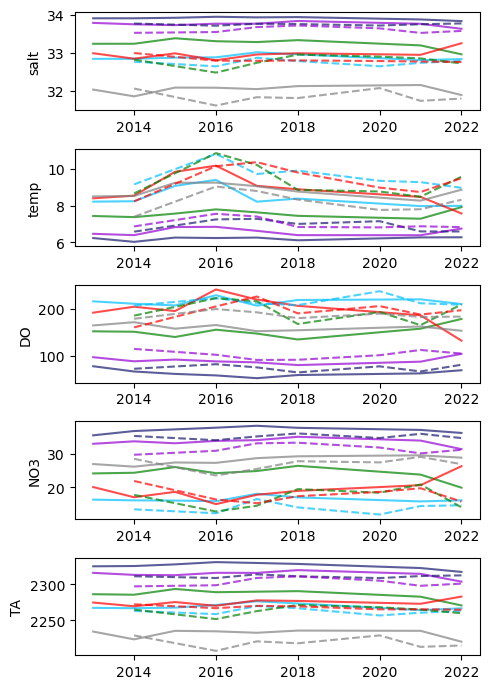

In [37]:
upyears = [2013, 2014, 2015, 2016, 2017, 2018, 2021, 2022]
downyears = [2014, 2016, 2017, 2018, 2020, 2021, 2022]
properties = ['salt','temp','DO','NO3','TA','DIC']

fig, ax = plt.subplots(5,1,figsize=(5,7))

for i in range(len(ax)):
    ax[i].plot(upyears, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7)
    ax[i].plot(upyears, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7)
    ax[i].plot(upyears, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7)
    ax[i].plot(upyears, interannual('north', properties[i], 'up'),c='green',alpha=0.7)
    ax[i].plot(upyears, interannual('south', properties[i], 'up'),c='red',alpha=0.7)
    # ax[i].plot(upyears, interannual('fresh', properties[i], 'up'),c='magenta',alpha=0.7)
    ax[i].plot(upyears, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7)
    ax[i].plot(downyears, interannual('cuc', properties[i], 'down'),ls='dashed',c='midnightblue',alpha=0.7)
    ax[i].plot(downyears, interannual('offshore deep', properties[i], 'down'),ls='dashed',c='darkviolet',alpha=0.7)
    ax[i].plot(downyears, interannual('offshore surface', properties[i], 'down'),ls='dashed',c='deepskyblue',alpha=0.7)
    ax[i].plot(downyears, interannual('north', properties[i], 'down'),ls='dashed',c='green',alpha=0.7)
    ax[i].plot(downyears, interannual('south', properties[i], 'down'),ls='dashed',c='red',alpha=0.7)
    # ax[i].plot(downyears, interannual('fresh', properties[i], 'down'),ls='dashed',c='magenta',alpha=0.7)
    ax[i].plot(downyears, interannual('loop', properties[i], 'down'),ls='dashed',c='grey',alpha=0.7)

    ax[i].set_ylabel(properties[i])

plt.tight_layout()

/tmp/ipykernel_54755/967043055.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data[i] = file[property][file.regions == region]


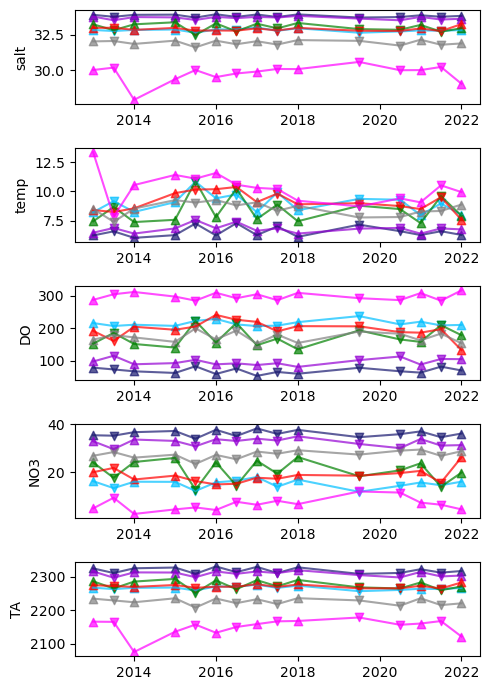

In [38]:
updownyears = np.sort(np.append(np.array(upyears),(np.array(downyears) - 0.5)))
properties = ['salt','temp','DO','NO3','TA','DIC']

fig, ax = plt.subplots(5,1,figsize=(5,7))

for i in range(len(ax)):
    ax[i].scatter(upyears, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('north', properties[i], 'up'),c='green',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('fresh', properties[i], 'up'),c='magenta',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax[i].scatter(np.array(downyears) - 0.5, interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('north', properties[i], 'down'),c='green',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('fresh', properties[i], 'down'),c='magenta',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    ax[i].plot(updownyears, interannual('cuc', properties[i], 'both'),c='midnightblue',alpha=0.7)
    ax[i].plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='darkviolet',alpha=0.7)
    ax[i].plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.7)
    ax[i].plot(updownyears, interannual('north', properties[i], 'both'),c='green',alpha=0.7)
    ax[i].plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.7)
    ax[i].plot(updownyears, interannual('fresh', properties[i], 'both'),c='magenta',alpha=0.7)
    ax[i].plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.7)

    ax[i].set_ylabel(properties[i])

plt.tight_layout()

In [40]:
upyears

[2013, 2014, 2015, 2016, 2017, 2018, 2021, 2022]

In [41]:
downyears

[2014, 2016, 2017, 2018, 2020, 2021, 2022]

/tmp/ipykernel_54755/967043055.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data[i] = file[property][file.regions == region]
/tmp/ipykernel_54755/967043055.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data[i] = file[property][file.regions == region]
/tmp/ipykernel_54755/967043055.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data[i] = file[property][file.regions == region]
/tmp/ipykernel_54755/967043055.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data[i] = file[property][file.regions == region]
/tmp/ipykernel_54755/967043055.py:12: FutureWarning: Calling float on a 

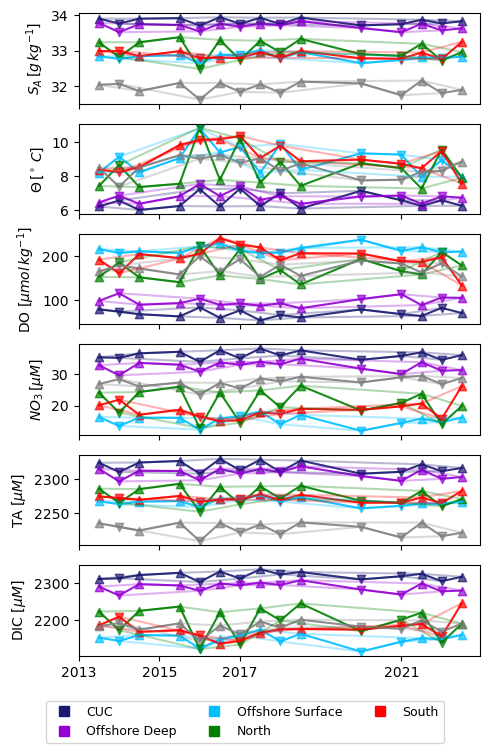

In [42]:
# don't actually keep fresh for final publication... too different from other water masses it makes the y-axis range bad
updownyears = np.sort(np.append(np.array(upyears)+0.5,(np.array(downyears))))
properties = ['salt','temp','DO','NO3','TA','DIC']
prop_names = ['$S_A \,[g\, kg^{-1}]$','$\Theta \,[^\circ \, C]$','DO $[\mu mol \, kg^{-1}]$','$NO_3 \, [\mu M]$','TA $[\mu M]$','DIC $[\mu M]$']

fig, ax = plt.subplots(6,1,figsize=(5,7))

for i in range(len(ax)):

    ax[i].plot(updownyears, interannual('cuc', properties[i], 'both'),c='midnightblue',alpha=0.9)
    ax[i].plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='darkviolet',alpha=0.9)
    ax[i].plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.9)
    ax[i].plot(updownyears, interannual('north', properties[i], 'both'),c='green',alpha=0.9)
    ax[i].plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.9)
    ax[i].plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.9)

    ax[i].scatter(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='green',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax[i].scatter(np.array(downyears), interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('north', properties[i], 'down'),c='green',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    # very transparrent line jsut for connecting upwelling and downwelling respectively?
    ax[i].plot(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='green',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.3)

    ax[i].plot((np.array(downyears)), interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('north', properties[i], 'down'),c='green',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('south', properties[i], 'down'),c='red',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('loop', properties[i], 'down'),c='grey',alpha=0.3)

    ax[i].set_xticks(upyears[::2])
    ax[i].set_xticklabels([])
    ax[i].set_ylabel(prop_names[i])

ax[5].set_xticklabels(upyears[::2])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South']
colours = ['midnightblue','darkviolet','deepskyblue','green','red']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

plt.tight_layout()
plt.savefig("/data1/bbeutel/LO_user/ariane/figures/modelpropvar.pdf", bbox_inches='tight')